# Anggota Kelompok Penalaran B

*   Ahmad Naufal Luthfan Marzuqi - 202210370311072
*   Agam Maulana Fransesco - 202210370311164



# Membangun Case Base

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Library

In [ ]:
!pip install pandas requests beautifulsoup4 pdfminer.six lxml lock> /dev/null 2>&1

In [ ]:
import argparse
import io
import os
import re
import time
import urllib
from concurrent.futures import ThreadPoolExecutor, wait
from datetime import date
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pdfminer.high_level import extract_text

## Pemrosesan Scraping Dari Putusan Hakim Medan (Pencurian)

In [ ]:
processed_cases_count = 0
from threading import Lock
lock = Lock()
MAX_FILES_TO_SCRAPE = 100

def create_path(folder_name):
    path = os.path.join(os.getcwd(), folder_name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

def open_page(link):
    count = 0
    while count < 3:
        try:
            return BeautifulSoup(requests.get(link).text, "lxml")
        except:
            count += 1
            time.sleep(5)

def get_detail(soup, keyword):
    try:
        text = (
            soup.find(lambda tag: tag.name == "td" and keyword in tag.text)
            .find_next()
            .get_text()
            .strip()
        )
        return text
    except:
        return ""

def get_pdf(url, path_pdf, case_number):
    try:
        file = urllib.request.urlopen(url)
        file_extension = os.path.splitext(url)[1]
        file_name = f"case_{case_number:03d}{file_extension}"
        file_content = file.read()
        full_path = os.path.join(path_pdf, file_name)
        with open(full_path, "wb") as out_file:
            out_file.write(file_content)
        return io.BytesIO(file_content), file_name, full_path
    except Exception as e:
        print(f"Error downloading PDF from {url}: {e}")
        return None, None, None

def clean_text(text):
    text = text.replace("M a h ka m a h A g u n g R e p u blik In d o n esia\n", "")
    text = text.replace("Disclaimer\n", "")
    text = text.replace(
        "Kepaniteraan Mahkamah Agung Republik Indonesia berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen Mahkamah Agung untuk pelayanan publik, transparansi dan akuntabilitas\n",
        "",
    )
    text = text.replace(
        "pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu.\n",
        "",
    )
    text = text.replace(
        "Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera hubungi Kepaniteraan Mahkamah Agung RI melalui :\n",
        "",
    )
    text = text.replace(
        "Email : kepaniteraan@mahkamahagung.go.id    Telp : 021-384 3348 (ext.318)\n",
        "",
    )
    return text

def extract_data(link, keyword_url, path_output_csv, path_output_txt, path_pdf, today, case_counter):
    soup = open_page(link)
    if not soup:
        print(f"Could not open page {link}, skipping case {case_counter}")
        return
    table = soup.find("table", {"class": "table"})
    judul = table.find("h2").text if table.find("h2") else ""

    nomor = get_detail(table, "Nomor")
    tingkat_proses = get_detail(table, "Tingkat Proses")
    klasifikasi = get_detail(table, "Klasifikasi")
    kata_kunci = get_detail(table, "Kata Kunci")
    tahun = get_detail(table, "Tahun")
    tanggal_register = get_detail(table, "Tanggal Register")
    lembaga_peradilan = get_detail(table, "Lembaga Peradilan")
    jenis_lembaga_peradilan = get_detail(table, "Jenis Lembaga Peradilan")
    hakim_ketua = get_detail(table, "Hakim Ketua")
    hakim_anggota = get_detail(table, "Hakim Anggota")
    panitera = get_detail(table, "Panitera")
    amar = get_detail(table, "Amar")
    amar_lainnya = get_detail(table, "Amar Lainnya")
    catatan_amar = get_detail(table, "Catatan Amar")
    tanggal_musyawarah = get_detail(table, "Tanggal Musyawarah")
    tanggal_dibacakan = get_detail(table, "Tanggal Dibacakan")
    kaidah = get_detail(table, "Kaidah")
    status = get_detail(table, "Status")
    abstrak = get_detail(table, "Abstrak")

    label_klasifikasi = "Perdata" if "perdata" in klasifikasi.lower() else "Pidana"

    text_pdf = ""
    file_name_pdf = ""
    link_pdf = ""
    pdf_saved_path = ""

    try:
        link_pdf_tag = soup.find("a", href=re.compile(r"/pdf/"))
        if link_pdf_tag:
            link_pdf = link_pdf_tag["href"]
            file_pdf_io, file_name_pdf, pdf_saved_path = get_pdf(link_pdf, path_pdf, case_counter)
            if file_pdf_io:
                text_pdf = extract_text(file_pdf_io)
                text_pdf = clean_text(text_pdf)
    except Exception as e:
        print(f"Error extracting PDF text for link {link_pdf}: {e}")
        link_pdf = ""
        text_pdf = ""
        file_name_pdf = ""
        pdf_saved_path = ""

    if text_pdf:
        txt_filename = f"case_{case_counter:03d}.txt"
        txt_full_path = os.path.join(path_output_txt, txt_filename)
        try:
            with open(txt_full_path, "w", encoding="utf-8") as txt_file:
                txt_file.write(text_pdf)
            print(f"Saved raw text to: {txt_full_path}")
        except Exception as e:
            print(f"Error saving raw text to {txt_full_path}: {e}")

    data = [
        judul,
        nomor,
        tingkat_proses,
        klasifikasi,
        kata_kunci,
        tahun,
        tanggal_register,
        lembaga_peradilan,
        jenis_lembaga_peradilan,
        hakim_ketua,
        hakim_anggota,
        panitera,
        amar,
        amar_lainnya,
        catatan_amar,
        tanggal_musyawarah,
        tanggal_dibacakan,
        kaidah,
        status,
        abstrak,
        link,
        link_pdf,
        file_name_pdf,
        text_pdf,
        pdf_saved_path,
        label_klasifikasi
    ]
    result = pd.DataFrame(
        [data],
        columns=[
            "judul",
            "nomor",
            "tingkat_proses",
            "klasifikasi",
            "kata_kunci",
            "tahun",
            "tanggal_register",
            "lembaga_peradilan",
            "jenis_lembaga_peradilan",
            "hakim_ketua",
            "hakim_anggota",
            "panitera",
            "amar",
            "amar_lainnya",
            "catatan_amar",
            "tanggal_musyawarah",
            "tanggal_dibacakan",
            "kaidah",
            "status",
            "abstrak",
            "link",
            "link_pdf",
            "file_name_pdf",
            "text_pdf",
            "pdf_saved_path",
            "label_klasifikasi"
        ],
    )

    keyword_url_clean = keyword_url.replace("/", "_").replace(":", "_").replace("?", "_").replace("=", "_").replace("&", "_")
    if keyword_url_clean.startswith("https"):
        keyword_url_clean = "url_scrape"
    destination = f"{path_output_csv}/putusan_ma_{keyword_url_clean}_{today}.csv"

    result.to_csv(destination, mode='a', header=not os.path.exists(destination), index=False)
    print(f"Appended data for case {case_counter} to CSV: {destination}")

def run_process(keyword_url, page, sort_date, path_output_csv, path_output_txt, path_pdf, today):
    global processed_cases_count, lock, MAX_FILES_TO_SCRAPE

    if keyword_url.startswith("https"):
        link = f"{keyword_url}&page={page}"
    else:
        link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword_url}&page={page}"
    if sort_date:
        link = f"{link}&obf=TANGGAL_PUTUS&obm=desc"

    soup = open_page(link)
    if not soup:
        print(f"Could not open page list {link}, skipping page.")
        return
    links = soup.find_all("a", {"href": re.compile("/direktori/putusan")})

    for link_tag in links:
        with lock:
            if processed_cases_count >= MAX_FILES_TO_SCRAPE:
                break
            processed_cases_count += 1
            current_case_number = processed_cases_count

        print(f"--- Processing case number: {current_case_number}/{MAX_FILES_TO_SCRAPE} ---")
        extract_data(link_tag["href"], keyword_url, path_output_csv, path_output_txt, path_pdf, today, current_case_number)

def run_scraper(keyword=None, url=None, sort_date=True, download_pdf=True):
    if not keyword and not url:
        print("Please provide a keyword or URL")
        return

    base_drive_path = '/content/drive/MyDrive/Penalaran'
    path_output_csv = os.path.join(base_drive_path, 'CSV')
    path_output_txt = os.path.join(base_drive_path, 'RAW_TEXT')
    path_pdf = os.path.join(base_drive_path, 'PDF')

    os.makedirs(path_output_csv, exist_ok=True)
    os.makedirs(path_output_txt, exist_ok=True)
    os.makedirs(path_pdf, exist_ok=True)

    today = date.today().strftime("%Y-%m-%d")

    link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword}&page=1"
    if url:
        link = url

    soup = open_page(link)
    if not soup:
        print(f"Failed to open initial page: {link}. Aborting.")
        return
    pagination_links = soup.find_all("a", {"class": "page-link"})
    if not pagination_links:
        print("No results found for the given keyword or URL.")
        return

    last_page = int(pagination_links[-1].get("data-ci-pagination-page"))

    if url:
        print(f"Scraping with url: {url} - approx {20 * last_page} data - {last_page} page")
        keyword_url = url
    else:
        print(f"Scraping with keyword: {keyword} - approx {20 * last_page} data - {last_page} page")
        keyword_url = keyword

    print(f"Scraping will stop after reaching {MAX_FILES_TO_SCRAPE} files.")

    futures = []

    with ThreadPoolExecutor(max_workers=4) as executor:
        for page in range(last_page):
            with lock:
                if processed_cases_count >= MAX_FILES_TO_SCRAPE:
                    print("Maximum file limit reached. No more pages will be submitted.")
                    break

            futures.append(
                executor.submit(run_process, keyword_url, page + 1, sort_date, path_output_csv, path_output_txt, path_pdf, today)
            )
    wait(futures)
    print(f"\n--- Scraping finished. Total files processed: {processed_cases_count} ---")


## Mendownload 100 file (PDF, TXT) dan raw CSV

In [ ]:
run_scraper(url="https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&cat=2c1ba6dc960f638b991a87475ede3d4c&jd=&tp=0&court=098629PN185|098629PN185%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20&t_put=2023&t_reg=&t_upl=&t_pr=")

Scraping with url: https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&cat=2c1ba6dc960f638b991a87475ede3d4c&jd=&tp=0&court=098629PN185|098629PN185%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20&t_put=2023&t_reg=&t_upl=&t_pr= - approx 920 data - 46 page
Scraping will stop after reaching 100 files.
--- Processing case number: 1/100 ---
--- Processing case number: 2/100 ---
--- Processing case number: 3/100 ---
--- Processing case number: 4/100 ---
Saved raw text to: /content/drive/MyDrive/Penalaran/RAW_TEXT/case_001.txt
Appended data for case 1 to CSV: /content/drive/MyDrive/Penalaran/CSV/putusan_ma_url_scrape_2025-06-23.csv
--- Processing case number: 5/100 ---
Saved raw text to: /content/drive/MyDrive/Penalaran/RAW_TEXT/case_002.txt
Appended data for case 2 to CSV: /content/drive/MyDrive/Penalaran/CSV/putusan_ma_url_scrape_2025-06-23.csv
--- Processing case number: 6/100 ---
Saved raw text to: /content/drive/MyDrive/Penalaran/RAW_TEXT/case_003.txt
Appe

# Case Representation

## Fungsi Raw CSV menjadi Processed CSV

In [ ]:
def find_latest_csv(folder_path):
    search_pattern = os.path.join(folder_path, '*.csv')
    csv_files = glob.glob(search_pattern)

    if not csv_files:
        print(f"Error: Tidak ada file CSV yang ditemukan di folder '{folder_path}'")
        return None

    latest_file = max(csv_files, key=os.path.getmtime)
    print(f"File CSV terbaru yang akan diproses: {os.path.basename(latest_file)}")
    return latest_file

def extract_pihak(judul_text):
    if not isinstance(judul_text, str):
        return "Tidak Diketahui"

    judul_lower = judul_text.lower()

    pemisah = None
    if 'melawan' in judul_lower:
        pemisah = 'melawan'
    elif 'lawan' in judul_lower:
        pemisah = 'lawan'
    elif ' vs ' in judul_lower:
        pemisah = ' vs '

    if pemisah:
        try:
            parts = re.split(pemisah, judul_text, maxsplit=1, flags=re.IGNORECASE)
            pihak1_raw = parts[0]
            if 'antara' in pihak1_raw.lower():
                pihak1 = re.split('antara', pihak1_raw, maxsplit=1, flags=re.IGNORECASE)[1].strip()
            else:
                pihak1 = pihak1_raw.split(',')[-1].strip()
            pihak2 = parts[1].strip()
            return f"{pihak1} vs. {pihak2}"
        except Exception:
            return "Gagal Ekstrak"

    return "Tidak Ditemukan Pemisah Pihak"

def create_summary(text, max_words=250):
    if not isinstance(text, str) or not text.strip():
        return "Teks tidak tersedia."

    words = text.split()
    summary_words = words[:max_words]
    summary = ' '.join(summary_words)

    if len(words) > max_words:
        summary += "..."

    return summary

print("Fungsi 'find_latest_csv', 'extract_pihak', dan 'create_summary' telah didefinisikan.")


Fungsi 'find_latest_csv', 'extract_pihak', dan 'create_summary' telah didefinisikan.


## Augmentasi Data

In [ ]:
base_drive_path = '/content/drive/MyDrive/Penalaran'
csv_input_path = os.path.join(base_drive_path, 'CSV')
processed_output_path = os.path.join(base_drive_path, 'Processed')

os.makedirs(processed_output_path, exist_ok=True)
print(f"Folder input: {csv_input_path}")
print(f"Folder output: {processed_output_path}")

latest_csv_file = find_latest_csv(csv_input_path)

if latest_csv_file:
    df_raw = pd.read_csv(latest_csv_file)
    print(f"\nBerhasil membaca {len(df_raw)} baris data.")
    print(f"Jumlah kolom asli: {len(df_raw.columns)}")

    df_processed = df_raw.copy()

    print("\nMemulai proses penambahan kolom baru...")

    df_processed.insert(0, 'case_id', range(1, len(df_processed) + 1))
    print(" - Kolom 'case_id' ditambahkan.")

    df_processed['pihak'] = df_processed['judul'].apply(extract_pihak)
    print(" - Kolom 'pihak' ditambahkan.")

    df_processed['ringkasan_fakta'] = df_processed['text_pdf'].apply(create_summary)
    print(" - Kolom 'ringkasan_fakta' ditambahkan.")

    print("\nProses penambahan kolom selesai.")
    print(f"Jumlah kolom sekarang: {len(df_processed.columns)}")

    output_filename = os.path.join(processed_output_path, 'processed_cases.csv')
    df_processed.to_csv(output_filename, index=False)

    print(f"\n[SUCCESS] Data yang telah di-augmentasi berhasil disimpan di:\n{output_filename}")

    print("\nBerikut adalah 5 baris pertama dari data yang sudah diproses (kolom asli + kolom baru):")
    display(df_processed[['case_id', 'nomor', 'pihak', 'ringkasan_fakta']].head())

else:
    print("\nProses dihentikan karena tidak ada file input yang bisa diolah.")


Folder input: /content/drive/MyDrive/Penalaran/CSV
Folder output: /content/drive/MyDrive/Penalaran/Processed
File CSV terbaru yang akan diproses: putusan_ma_url_scrape_2025-06-23.csv

Berhasil membaca 100 baris data.
Jumlah kolom asli: 26

Memulai proses penambahan kolom baru...
 - Kolom 'case_id' ditambahkan.
 - Kolom 'pihak' ditambahkan.
 - Kolom 'ringkasan_fakta' ditambahkan.

Proses penambahan kolom selesai.
Jumlah kolom sekarang: 29

[SUCCESS] Data yang telah di-augmentasi berhasil disimpan di:
/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv

Berikut adalah 5 baris pertama dari data yang sudah diproses (kolom asli + kolom baru):


,case_id,nomor,pihak,ringkasan_fakta
0,1,Putusan PN MEDAN Nomor 2065/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Direktori Putusan Mahkamah Agung Republik Indo...
1,2,Putusan PN MEDAN Nomor 1995/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Direktori Putusan Mahkamah Agung Republik Indo...
2,3,Putusan PN MEDAN Nomor 2138/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Direktori Putusan Mahkamah Agung Republik Indo...
3,4,Putusan PN MEDAN Nomor 2066/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Direktori Putusan Mahkamah Agung Republik Indo...
4,5,Putusan PN MEDAN Nomor 2114/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Direktori Putusan Mahkamah Agung Republik Indo...


## Verifikasi Hasil CSV

In [ ]:
output_file_to_check = '/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv'

try:
    print(f"Membaca file hasil proses dari: {output_file_to_check}")
    df_final = pd.read_csv(output_file_to_check)

    print("\nJumlah kolom di file hasil akhir:", len(df_final.columns))
    print("Nama kolom:", df_final.columns.tolist())

    print("\nMenampilkan 5 baris teratas dari file hasil akhir (beberapa kolom kunci):")
    display(df_final[['case_id', 'nomor', 'pihak', 'ringkasan_fakta', 'label_klasifikasi']].head())

except FileNotFoundError:
    print(f"Error: File '{output_file_to_check}' tidak ditemukan. Pastikan Section 3 berjalan tanpa error.")

Membaca file hasil proses dari: /content/drive/MyDrive/Penalaran/Processed/processed_cases.csv

Jumlah kolom di file hasil akhir: 30
Nama kolom: ['case_id', 'judul', 'nomor', 'tingkat_proses', 'klasifikasi', 'kata_kunci', 'tahun', 'tanggal_register', 'lembaga_peradilan', 'jenis_lembaga_peradilan', 'hakim_ketua', 'hakim_anggota', 'panitera', 'amar', 'amar_lainnya', 'catatan_amar', 'tanggal_musyawarah', 'tanggal_dibacakan', 'kaidah', 'status', 'abstrak', 'link', 'link_pdf', 'file_name_pdf', 'text_pdf', 'pdf_saved_path', 'label_klasifikasi', 'pihak', 'ringkasan_fakta', 'ringkasan_manual']

Menampilkan 5 baris teratas dari file hasil akhir (beberapa kolom kunci):


,case_id,nomor,pihak,ringkasan_fakta,label_klasifikasi
0,1,Putusan PN MEDAN Nomor 2065/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Kasus ini terkait tindak pidana Pencurian. Ter...,Berat
1,2,Putusan PN MEDAN Nomor 1995/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Kasus ini terkait tindak pidana Pencurian. Ter...,Berat
2,3,Putusan PN MEDAN Nomor 2138/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Kasus ini terkait tindak pidana Pencurian. Ter...,Ringan
3,4,Putusan PN MEDAN Nomor 2066/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Kasus ini terkait tindak pidana Pencurian. Ter...,Ringan
4,5,Putusan PN MEDAN Nomor 2114/Pid.B/2023/PN Mdn ...,Tidak Ditemukan Pemisah Pihak,Kasus ini terkait tindak pidana Pencurian. Ter...,Ringan


## Membaca Kembali Isi Yang Diproses

In [ ]:
import pandas as pd
import os
import re

processed_file_path = '/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv'

try:
    # Kita akan bekerja dengan DataFrame bernama df_final
    df_final = pd.read_csv(processed_file_path)
    print(f"Berhasil memuat {len(df_final)} baris data dari {processed_file_path}")
    print("Contoh data:")
    display(df_final[['case_id', 'nomor', 'label_klasifikasi']].head())
except FileNotFoundError:
    print(f"Error: File '{processed_file_path}' tidak ditemukan. Pastikan Anda sudah menjalankan tahap sebelumnya.")

Berhasil memuat 100 baris data dari /content/drive/MyDrive/Penalaran/Processed/processed_cases.csv
Contoh data:


,case_id,nomor,label_klasifikasi
0,1,Putusan PN MEDAN Nomor 2065/Pid.B/2023/PN Mdn ...,Berat
1,2,Putusan PN MEDAN Nomor 1995/Pid.B/2023/PN Mdn ...,Berat
2,3,Putusan PN MEDAN Nomor 2138/Pid.B/2023/PN Mdn ...,Ringan
3,4,Putusan PN MEDAN Nomor 2066/Pid.B/2023/PN Mdn ...,Ringan
4,5,Putusan PN MEDAN Nomor 2114/Pid.B/2023/PN Mdn ...,Ringan


## Ekstraksi Detail Kasus

In [ ]:
def extract_case_details(row):
    amar = row.get('amar', '')
    kata_kunci = row.get('kata_kunci', '')
    text = row.get('text_pdf', '')

    if not isinstance(text, str) or not isinstance(amar, str):
        return "Data tidak lengkap untuk membuat ringkasan."

    terdakwa_match = re.search(r'Menyatakan Terdakwa\s(?:I\.?\s*)?(.+?)\s*terbukti secara sah', text, re.IGNORECASE | re.DOTALL)
    terdakwa = terdakwa_match.group(1).strip().replace('\n', ' ') if terdakwa_match else "Tidak disebutkan"

    tindak_pidana = kata_kunci.strip() if isinstance(kata_kunci, str) and kata_kunci.strip() else "Tidak disebutkan"

    barang_bukti_match = re.search(r'Barang Bukti\s*:\s*(.+?)(?:Menetapkan agar|Membebankan)', amar, re.IGNORECASE | re.DOTALL)
    barang_bukti = barang_bukti_match.group(1).strip().replace('\n', ' ').replace('  ', ' ') if barang_bukti_match else "Tidak disebutkan"
    if len(barang_bukti) > 300:
        barang_bukti = barang_bukti[:300] + "..."

    putusan_match = re.search(r'pidana (penjara selama .+?)(?:\s*dan denda|,|$)|(denda sebesar .+) ', amar, re.IGNORECASE | re.DOTALL)
    putusan = putusan_match.group(1).strip() if putusan_match and putusan_match.group(1) else (putusan_match.group(2).strip() if putusan_match and putusan_match.group(2) else "Tidak disebutkan")

    pasal_patterns = [
        r'melanggar Pasal\s*(.+?)\s*Undang-Undang',
        r'sebagaimana diatur dan diancam pidana dalam Pasal\s*(.+?)\s*[A-Za-z]',
        r'dalam Pasal\s+(.+?)\s*Dakwaan'
    ]
    pasal = "Tidak disebutkan"
    for pattern in pasal_patterns:
        pasal_match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if pasal_match:
            pasal = pasal_match.group(1).strip().replace('\n', ' ')
            break

    summary = (
        f"**Terdakwa:** {terdakwa}\n"
        f"**Tindak Pidana:** {tindak_pidana}\n"
        f"**Pasal yang Dilanggar:** {pasal}\n"
        f"**Putusan:** {putusan}\n"
        f"**Barang Bukti:** {barang_bukti}"
    )
    return summary

print("Fungsi 'extract_case_details' telah didefinisikan dan siap digunakan.")


Fungsi 'extract_case_details' telah didefinisikan dan siap digunakan.


## Melakukan Pelabelan Berdasar Masa Pidana

In [ ]:
def get_punishment_category_from_text(row):
    text = row.get('text_pdf', '')

    if not isinstance(text, str) or not text.strip():
        return "Tidak Ditemukan"

    pattern = r'Menjatuhkan pidana.*?selama\s+(\d+)\s*(?:\(.+?\))?\s*(tahun|bulan|hari)'

    matches = re.findall(pattern, text, re.IGNORECASE | re.DOTALL)

    if not matches:
        if re.search(r'pidana denda|menyatakan terdakwa.*tidak terbukti|putusan bebas', text, re.IGNORECASE | re.DOTALL):
            return "Non-Penjara / Bebas"
        return "Tidak Ditemukan"

    total_hari = 0
    for value_str, unit in matches:
        value = int(value_str)
        unit_lower = unit.lower()

        if 'tahun' in unit_lower:
            total_hari += value * 365
        elif 'bulan' in unit_lower:
            total_hari += value * 30
        elif 'hari' in unit_lower:
            total_hari += value

    if total_hari == 0:
        return "Tidak Ditemukan"

    batas_ringan_hari = 1095

    if total_hari <= batas_ringan_hari:
        return "Ringan"
    else:
        return "Berat"


## Membuat Kolom Ringkasan

In [ ]:
if 'df_final' in locals():
    print("Menerapkan fungsi `extract_case_details` ke setiap baris. Mohon tunggu...")

    df_final['ringkasan_manual'] = df_final.apply(extract_case_details, axis=1)

    print("\nProses selesai! Kolom 'ringkasan_manual' telah ditambahkan.")

    print("Contoh hasil 'ringkasan_manual' dari 5 baris pertama:")
    for index, row in df_final.head().iterrows():
        print(f"\n--- KASUS {row['case_id']} ---")
        print(row['ringkasan_manual'])
        print("--------------------")

else:
    print("Error: DataFrame 'df_final' tidak ditemukan. Jalankan Section 3 terlebih dahulu.")

Menerapkan fungsi `extract_case_details` ke setiap baris. Mohon tunggu...

Proses selesai! Kolom 'ringkasan_manual' telah ditambahkan.
Contoh hasil 'ringkasan_manual' dari 5 baris pertama:

--- KASUS 1 ---
**Terdakwa:** KASIONO Alias KASBEL terbuktibersalah melakukan “pencurian dengan keadaan yang memberatkan”sebagaimana diatur dan diancam pidana dalam Pasal 363 Ayat (1) ke-5KUHP sebagaimana dalam dakwaan tunggal Penuntut Umum.Halaman 1 dari 16 Putusan Nomor 2065/Pid.B/2023/PN MdnDirektori Putusan Mahkamah Agung Republik Indonesia putusan.mahkamahagung.go.id  Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia   Halaman 2  2.Menjatuhkan pidana penjara selama 3 (tiga) tahun dikurangiselama Terdakwa berada dalam tahanan sementara dan dengan perintahagar Terdakwa tetap di tahan.3.Menyatakan barang bukti berupa:-1 (satu) buah kunci leter TDirampas untuk dimusnahkan-1 (satu

## Output Hasil Proses

In [ ]:
if 'df_final' in locals():
    print("Memperbarui kolom 'label_klasifikasi' berdasarkan durasi dari 'text_pdf'...")

    df_final['label_klasifikasi'] = df_final.apply(get_punishment_category_from_text, axis=1)

    print("Proses selesai!")

    # --- VERIFIKASI HASIL ---
    print("\nMenampilkan contoh hasil untuk verifikasi:")
    display_cols = ['case_id', 'ringkasan_manual', 'label_klasifikasi']

    print("\nContoh Kategori 'Ringan':")
    display(df_final[df_final['label_klasifikasi'] == 'Ringan'][display_cols].head())

    print("\nContoh Kategori 'Berat':")
    display(df_final[df_final['label_klasifikasi'] == 'Berat'][display_cols].head())

    print("\nDistribusi nilai baru di kolom 'label_klasifikasi':")
    print(df_final['label_klasifikasi'].value_counts())

else:
    print("Error: DataFrame 'df_final' tidak ditemukan. Harap muat data Anda terlebih dahulu.")

Memperbarui kolom 'label_klasifikasi' berdasarkan durasi dari 'text_pdf'...
Proses selesai!

Menampilkan contoh hasil untuk verifikasi:

Contoh Kategori 'Ringan':


,case_id,ringkasan_manual,label_klasifikasi
2,3,**Terdakwa:** Azri Famriza Tarigan telah terbu...,Ringan
3,4,**Terdakwa:** SAIDI AMRI NAPITUPULU Alias BAPA...,Ringan
4,5,**Terdakwa:** HERY ZULHAM ALS ILHAM telah terb...,Ringan
5,6,**Terdakwa:** MUKLIS GULO Alias RISMAN dan Ter...,Ringan
9,10,**Terdakwa:** ROMULUS NADAPDAP Als SAULUS seca...,Ringan



Contoh Kategori 'Berat':


,case_id,ringkasan_manual,label_klasifikasi
0,1,**Terdakwa:** KASIONO Alias KASBEL terbuktiber...,Berat
1,2,"**Terdakwa:** Achmad Afandi Lubis, Terdakwa II...",Berat
6,7,**Terdakwa:** MELVIN SOUFIARTO alias JEMMEK se...,Berat
7,8,**Terdakwa:** LEONARDO HUTASOIT secara sah dan...,Berat
8,9,"**Terdakwa:** Rudi Hartono alias Gencet, terda...",Berat



Distribusi nilai baru di kolom 'label_klasifikasi':
label_klasifikasi
Ringan             39
Berat              35
Tidak Ditemukan    26
Name: count, dtype: int64


## Fungsi Untuk Ringkasan Fakta

In [ ]:
import re

def generate_narrative_summary(row):
    amar = row.get('amar', '')
    kata_kunci = row.get('kata_kunci', '')
    text = row.get('text_pdf', '')

    if not isinstance(text, str) or not isinstance(amar, str):
        return "Data tidak lengkap."

    terdakwa_match = re.search(r'Menyatakan Terdakwa\s(?:I\.?\s*)?(.+?)\s*terbukti secara sah', amar, re.IGNORECASE | re.DOTALL)
    terdakwa = terdakwa_match.group(1).strip().replace('\n', ' ') if terdakwa_match else None

    tindak_pidana = kata_kunci.strip() if isinstance(kata_kunci, str) and kata_kunci.strip() else None

    putusan_match = re.search(r'pidana (penjara selama .+?)(?:\s*dan denda|,|$)|(denda sebesar .+) ', amar, re.IGNORECASE | re.DOTALL)
    putusan = putusan_match.group(1).strip() if putusan_match and putusan_match.group(1) else (putusan_match.group(2).strip() if putusan_match and putusan_match.group(2) else None)

    pasal_patterns = [
        r'melanggar Pasal\s*(.+?)\s*Undang-Undang',
        r'sebagaimana diatur dan diancam pidana dalam Pasal\s*(.+?)\s*[A-Za-z]',
        r'dalam Pasal\s+(.+?)\s*Dakwaan'
    ]
    pasal = None
    for pattern in pasal_patterns:
        pasal_match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if pasal_match:
            pasal = pasal_match.group(1).strip().replace('\n', ' ')
            break

    summary_parts = []

    if terdakwa:
        summary_parts.append(f"Terdakwa bernama {terdakwa}")

    if tindak_pidana:
        if summary_parts:
            summary_parts.append(f"didakwa melakukan tindak pidana {tindak_pidana}.")
        else:
            summary_parts.append(f"Kasus ini terkait tindak pidana {tindak_pidana}.")

    if pasal:
        summary_parts.append(f"Terdakwa dijerat dengan {pasal}.")

    if putusan:
        summary_parts.append(f"Hakim menjatuhkan putusan berupa {putusan}.")

    if not summary_parts:
        return "Informasi penting tidak dapat diekstrak secara otomatis dari teks."

    return ' '.join(summary_parts)

print("Fungsi 'generate_narrative_summary' telah didefinisikan dan siap digunakan.")


Fungsi 'generate_narrative_summary' telah didefinisikan dan siap digunakan.


## Menerapkan Fungsi dan Output

In [ ]:
if 'df_final' in locals():
    print("Memperbarui kolom 'ringkasan_fakta' dengan ringkasan naratif yang bersih. Mohon tunggu...")

    df_final['ringkasan_fakta'] = df_final.apply(generate_narrative_summary, axis=1)

    print("\nProses selesai! Kolom 'ringkasan_fakta' telah diperbarui.")

    print("Perbandingan antara 'ringkasan_fakta' (baru) dan 'ringkasan_manual' (lama):")
    display(df_final[['ringkasan_fakta', 'ringkasan_manual', 'label_klasifikasi']].head())

else:
    print("Error: DataFrame 'df_final' tidak ditemukan. Jalankan section sebelumnya terlebih dahulu.")

Memperbarui kolom 'ringkasan_fakta' dengan ringkasan naratif yang bersih. Mohon tunggu...

Proses selesai! Kolom 'ringkasan_fakta' telah diperbarui.
Perbandingan antara 'ringkasan_fakta' (baru) dan 'ringkasan_manual' (lama):


,ringkasan_fakta,ringkasan_manual,label_klasifikasi
0,Kasus ini terkait tindak pidana Pencurian. Ter...,**Terdakwa:** KASIONO Alias KASBEL terbuktiber...,Berat
1,Kasus ini terkait tindak pidana Pencurian. Ter...,"**Terdakwa:** Achmad Afandi Lubis, Terdakwa II...",Berat
2,Kasus ini terkait tindak pidana Pencurian. Ter...,**Terdakwa:** Azri Famriza Tarigan telah terbu...,Ringan
3,Kasus ini terkait tindak pidana Pencurian. Ter...,**Terdakwa:** SAIDI AMRI NAPITUPULU Alias BAPA...,Ringan
4,Kasus ini terkait tindak pidana Pencurian. Ter...,**Terdakwa:** HERY ZULHAM ALS ILHAM telah terb...,Ringan


## Menyimpan Hasil Keseluruhan Proses

In [ ]:
if 'df_final' in locals() and 'ringkasan_manual' in df_final.columns:
    output_final_path = '/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv'
    print(f"Menyimpan hasil akhir yang sudah bersih ke: {output_final_path}")
    df_final.to_csv(output_final_path, index=False)
    print("File berhasil disimpan.")
else:
    print("Tidak ada data untuk disimpan. Pastikan Section 5 berjalan dengan sukses.")

Menyimpan hasil akhir yang sudah bersih ke: /content/drive/MyDrive/Penalaran/Processed/processed_cases.csv
File berhasil disimpan.


# Case Retrieval

In [2]:
!pip install transformers[torch] sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## Memuat Dataset yang sudah diproses dan melakukan cleaning

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

file_path = '/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat.")
    print(f"Jumlah baris: {len(df)}")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di path '{file_path}'. Pastikan path sudah benar.")
    exit()

text_columns = ['judul', 'ringkasan_fakta', 'kaidah', 'amar']
for col in text_columns:
    df[col] = df[col].fillna('')

df['text_for_retrieval'] = df['judul'] + '. ' + df['ringkasan_fakta'] + '. ' + df['kaidah'] + '. ' + df['amar']

print("\nContoh Teks Gabungan untuk Retrieval (text_for_retrieval):")
print(df['text_for_retrieval'].iloc[0])

print("\nInformasi DataFrame setelah pra-pemrosesan:")
df.info()

Dataset berhasil dimuat.
Jumlah baris: 100

Contoh Teks Gabungan untuk Retrieval (text_for_retrieval):
Putusan PN MEDAN Nomor 2065/Pid.B/2023/PN Mdn Tanggal 13 Desember 2023 —Penuntut Umum:franciskawati nainggolanTerdakwa:KASIONO Alias KASBEL. Kasus ini terkait tindak pidana Pencurian. Terdakwa dijerat dengan 363.. —. Lain-lain

Informasi DataFrame setelah pra-pemrosesan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   case_id                  100 non-null    int64  
 1   judul                    100 non-null    object 
 2   nomor                    100 non-null    object 
 3   tingkat_proses           100 non-null    object 
 4   klasifikasi              100 non-null    object 
 5   kata_kunci               100 non-null    object 
 6   tahun                    100 non-null    int64  
 7   tanggal_register         100 n

## Representasi Vektor TF-IDF

In [4]:
print("\n" + "="*50)
print("Pendekatan 1: Statistik (TF-IDF)")
print("="*50)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000,
                             ngram_range=(1, 2))

tfidf_matrix = vectorizer.fit_transform(df['text_for_retrieval'])

print(f"\nBentuk matriks TF-IDF: {tfidf_matrix.shape}")
print(f"(Jumlah Dokumen, Jumlah Fitur/Kata Unik)")
print("\nContoh beberapa fitur yang dipelajari:")
print(list(vectorizer.get_feature_names_out())[1000:1010])


Pendekatan 1: Statistik (TF-IDF)

Bentuk matriks TF-IDF: (100, 5000)
(Jumlah Dokumen, Jumlah Fitur/Kata Unik)

Contoh beberapa fitur yang dipelajari:
['charge', 'cincin', 'cincin emas', 'cm', 'cm jarak', 'coklat', 'coklat milik', 'conditioner', 'conditioner ac', 'cor']


## Retrieve TF-IDF

In [5]:
def retrieve_with_tfidf(query, top_n=5):

    print(f"\nMelakukan retrieval untuk kueri: '{query}'")

    query_vector = vectorizer.transform([query])

    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

    related_docs_indices = cosine_similarities.argsort()[-top_n:][::-1]

    print(f"\nTop {top_n} hasil pencarian:")
    for i, idx in enumerate(related_docs_indices):
        print(f"case id :{df['case_id'].iloc[idx]}")
        print(f"{i+1}. Judul: {df['judul'].iloc[idx]}")
        print(f"   Skor Kemiripan: {cosine_similarities[idx]:.4f}")
        print(f"   Link: {df['link'].iloc[idx]}")
        print("-" * 20)

query_hukum = "Mahkamah Agung Republik Indonesia memproses kasus pencurian ini secara transparan dengan menghadirkan saksi dan terdakwa"
retrieve_with_tfidf(query_hukum, top_n=5)


Melakukan retrieval untuk kueri: 'Mahkamah Agung Republik Indonesia memproses kasus pencurian ini secara transparan dengan menghadirkan saksi dan terdakwa'

Top 5 hasil pencarian:
case id :40
1. Judul: Putusan PN MEDAN Nomor 2092/Pid.B/2023/PN Mdn Tanggal 12 Desember 2023 —Penuntut Umum:RAHMAYANI AMIR AHMAD, SHTerdakwa:Andri Agustian
   Skor Kemiripan: 0.4913
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaef31c5afb5b606aa84303830343139.html
--------------------
case id :19
2. Judul: Putusan PN MEDAN Nomor 1986/Pid.B/2023/PN Mdn Tanggal 6 Desember 2023 —Penuntut Umum:RIZKIE ANDRIANI HARAHAP,SHTerdakwa:MUHAMMAD SURYADI
   Skor Kemiripan: 0.4554
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaef11cd89aaafa6b04c313533393534.html
--------------------
case id :71
3. Judul: Putusan PN MEDAN Nomor 2254/Pid.B/2023/PN Mdn Tanggal 20 Desember 2023 —Penuntut Umum:ELVINA ELISABETH SIANIPAR,SHTerdakwa:INDRA PUTRA PRATAMA
   Skor Kemiripan: 0.4546
   Link: https:

## Klasifikasi TF-IDF dengan SVM

In [6]:
def classify_with_svm(query):

    print("\n" + "="*50)
    print("Contoh Klasifikasi dengan SVM pada representasi TF-IDF")
    print("="*50)

    X = tfidf_matrix
    y = df['label_klasifikasi']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Melatih model SVM...")
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(X_train, y_train)
    print("Model SVM selesai dilatih.")

    print("\nLaporan Klasifikasi pada Data Test:")
    y_pred = svm_model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))

    print(f"\nMemprediksi klasifikasi untuk kueri: '{query}'")
    query_vector = vectorizer.transform([query])
    predicted_class = svm_model.predict(query_vector)
    predicted_proba = svm_model.predict_proba(query_vector).max()

    print(f"\nHasil Prediksi Klasifikasi: '{predicted_class[0]}'")
    print(f"Skor Kepercayaan: {predicted_proba:.4f}")

classify_with_svm(query_hukum)


Contoh Klasifikasi dengan SVM pada representasi TF-IDF
Melatih model SVM...
Model SVM selesai dilatih.

Laporan Klasifikasi pada Data Test:
                 precision    recall  f1-score   support

          Berat       0.57      0.57      0.57         7
         Ringan       0.70      0.88      0.78         8
Tidak Ditemukan       1.00      0.60      0.75         5

       accuracy                           0.70        20
      macro avg       0.76      0.68      0.70        20
   weighted avg       0.73      0.70      0.70        20


Memprediksi klasifikasi untuk kueri: 'Mahkamah Agung Republik Indonesia memproses kasus pencurian ini secara transparan dengan menghadirkan saksi dan terdakwa'

Hasil Prediksi Klasifikasi: 'Ringan'
Skor Kepercayaan: 0.4891


## Representasi Vektor IndoBERT

In [7]:
print("\n" + "="*50)
print("Pendekatan 2: Text Embedding (IndoBERT)")
print("="*50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

model_name = 'indobenchmark/indobert-base-p1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

def get_bert_embedding(text, max_length=512):
    encoded_input = tokenizer(text,
                              padding=True,
                              truncation=True,
                              max_length=max_length,
                              return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)

    last_hidden_state = model_output.last_hidden_state
    input_mask_expanded = encoded_input['attention_mask'].unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    embedding = sum_embeddings / sum_mask

    return embedding.cpu().numpy().flatten()

print("\nMembuat embedding untuk semua dokumen... (Proses ini mungkin memakan waktu)")
tqdm.pandas(desc="Membuat Embedding")
doc_embeddings = df['text_for_retrieval'].progress_apply(get_bert_embedding)
doc_embeddings_matrix = np.vstack(doc_embeddings.values)

print(f"\nEmbedding selesai dibuat.")
print(f"Bentuk matriks embedding: {doc_embeddings_matrix.shape}")



Pendekatan 2: Text Embedding (IndoBERT)
Menggunakan device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Membuat embedding untuk semua dokumen... (Proses ini mungkin memakan waktu)


Membuat Embedding:   0%|          | 0/100 [00:00<?, ?it/s]


Embedding selesai dibuat.
Bentuk matriks embedding: (100, 768)


## Retrieve BERT

In [8]:
def retrieve_with_bert(query, top_n=5):
    print(f"\nMelakukan retrieval untuk kueri: '{query}'")

    query_embedding = get_bert_embedding(query)
    query_embedding = query_embedding.reshape(1, -1)

    cosine_similarities = cosine_similarity(query_embedding, doc_embeddings_matrix).flatten()

    related_docs_indices = cosine_similarities.argsort()[-top_n:][::-1]

    print(f"\nTop {top_n} hasil pencarian (menggunakan IndoBERT):")
    for i, idx in enumerate(related_docs_indices):
        print(f"case id :{df['case_id'].iloc[idx]}")
        print(f"{i+1}. Judul: {df['judul'].iloc[idx]}")
        print(f"   Skor Kemiripan: {cosine_similarities[idx]:.4f}")
        print(f"   Link: {df['link'].iloc[idx]}")
        print("-" * 20)

retrieve_with_bert(query_hukum, top_n=5)


Melakukan retrieval untuk kueri: 'Mahkamah Agung Republik Indonesia memproses kasus pencurian ini secara transparan dengan menghadirkan saksi dan terdakwa'

Top 5 hasil pencarian (menggunakan IndoBERT):
case id :59
1. Judul: Putusan PN MEDAN Nomor 2129/Pid.B/2023/PN Mdn Tanggal 6 Desember 2023 —Penuntut Umum:Pantun Marojahan Simbolon,SHTerdakwa:FERRY CHANDRA
   Skor Kemiripan: 0.5984
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaef11a945b126fab9ba313132303138.html
--------------------
case id :34
2. Judul: Putusan PN MEDAN Nomor 2049/Pid.B/2023/PN Mdn Tanggal 6 Desember 2023 —Penuntut Umum:franciskawati nainggolanTerdakwa:MARIHOT MANULANG Alias MARIHOT
   Skor Kemiripan: 0.5967
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaef11cdacebd79ca9ed313534303533.html
--------------------
case id :69
3. Judul: Putusan PN MEDAN Nomor 1858/Pid.B/2023/PN Mdn Tanggal 7 Desember 2023 —Penuntut Umum:SARAH MARISI IRENEY SIDAURUKTerdakwa:EDI SUDARSONO Alias EDI
 

## Pembuatan Query untuk Pengujian

In [9]:
import json
import os

print("\n" + "="*50)
print("v. Pengujian Awal (Evaluasi Sistem Retrieval) - Edisi Revisi")
print("="*50)

evaluation_queries = [
    {
        "query": "pencurian terdakwa saksi mahkamah agung republik indonesia",
        "ground_truth_case_id": 40,
        "notes": "Query referensi dari user (keyword-based)."
    },
    {
        "query": "Terdakwa pencurian mengajukan banding ke Mahkamah Agung Republik Indonesia setelah kesaksian saksi memberatkannya",
        "ground_truth_case_id": 40,
        "notes": "Query semantik untuk kasus narkotika."
    },
    {
        "query": "Mahkamah Agung Republik Indonesia menjatuhkan vonis kepada terdakwa pencurian setelah mendengarkan saksi",
        "ground_truth_case_id": 40,
        "notes": "Query spesifik untuk kasus perdata."
    },
    {
        "query": "Mahkamah Agung Republik Indonesia memproses kasus pencurian ini secara transparan dengan menghadirkan saksi dan terdakwa",
        "ground_truth_case_id": 59,
        "notes": "Query semantik untuk kasus korupsi."
    },
    {
        "query": "Republik Indonesia menindak tegas pelaku pencurian",
        "ground_truth_case_id": 5,
        "notes": "Query untuk kasus pidana umum."
    }
]

eval_dir = '/content/drive/MyDrive/Penalaran/data/eval'
os.makedirs(eval_dir, exist_ok=True)

json_path = os.path.join(eval_dir, 'queries.json')

with open(json_path, 'w') as f:
    json.dump(evaluation_queries, f, indent=4)

print(f"\nFile pengujian berhasil disimpan di: '{json_path}'")
print("\nIsi file 'queries.json':")
with open(json_path, 'r') as f:
    print(f.read())



v. Pengujian Awal (Evaluasi Sistem Retrieval) - Edisi Revisi

File pengujian berhasil disimpan di: '/content/drive/MyDrive/Penalaran/data/eval/queries.json'

Isi file 'queries.json':
[
    {
        "query": "pencurian terdakwa saksi mahkamah agung republik indonesia",
        "ground_truth_case_id": 40,
        "notes": "Query referensi dari user (keyword-based)."
    },
    {
        "query": "Terdakwa pencurian mengajukan banding ke Mahkamah Agung Republik Indonesia setelah kesaksian saksi memberatkannya",
        "ground_truth_case_id": 40,
        "notes": "Query semantik untuk kasus narkotika."
    },
    {
        "query": "Mahkamah Agung Republik Indonesia menjatuhkan vonis kepada terdakwa pencurian setelah mendengarkan saksi",
        "ground_truth_case_id": 40,
        "notes": "Query spesifik untuk kasus perdata."
    },
    {
        "query": "Mahkamah Agung Republik Indonesia memproses kasus pencurian ini secara transparan dengan menghadirkan saksi dan terdakwa",
        

## Fungsi Retrieval

In [10]:
def retrieve(query: str, method: str, top_n: int = 5,
             df_data=df,
             tfidf_vec=vectorizer, tfidf_mat=tfidf_matrix,
             bert_model_func=get_bert_embedding, doc_embed_mat=doc_embeddings_matrix):

    if method.lower() not in ['tfidf', 'bert']:
        raise ValueError("Metode harus 'tfidf' atau 'bert'")

    if method.lower() == 'tfidf':
        query_vector = tfidf_vec.transform([query])
        similarities = cosine_similarity(query_vector, tfidf_mat).flatten()
    elif method.lower() == 'bert':
        query_embedding = bert_model_func(query).reshape(1, -1)
        similarities = cosine_similarity(query_embedding, doc_embed_mat).flatten()

    top_indices = similarities.argsort()[-top_n:][::-1]
    results_df = df_data.iloc[top_indices].copy()
    results_df['score'] = similarities[top_indices]
    return results_df[['case_id', 'judul', 'score', 'link']]

## Pengujian

In [11]:
print("\n" + "="*50)
print("vi. Menjalankan Skrip Evaluasi Retrieval pada 'queries.json'")
print("="*50)

with open(json_path, 'r') as f:
    queries_to_evaluate = json.load(f)

total_queries = len(queries_to_evaluate)
tfidf_hits_at_5 = 0
bert_hits_at_5 = 0

print(f"Memulai evaluasi untuk {total_queries} kueri...\n")

for i, item in enumerate(queries_to_evaluate):
    query_text = item['query']
    ground_truth_id = item['ground_truth_case_id']
    notes = item.get('notes', '')

    print(f"--- Evaluasi Query #{i+1}: '{query_text}' ---")
    print(f"Ground Truth Case ID: {ground_truth_id} | Notes: {notes}")

    print("\n  Hasil dari TF-IDF:")
    tfidf_results = retrieve(query=query_text, method='tfidf', top_n=5)
    print(tfidf_results)
    if ground_truth_id in tfidf_results['case_id'].values:
        tfidf_hits_at_5 += 1
        print("  -> Status TF-IDF: HIT")
    else:
        print("  -> Status TF-IDF: MISS")

    print("\n  Hasil dari BERT:")
    bert_results = retrieve(query=query_text, method='bert', top_n=5)
    print(bert_results)
    # Cek apakah ground truth ada di hasil
    if ground_truth_id in bert_results['case_id'].values:
        bert_hits_at_5 += 1
        print("  -> Status BERT: HIT")
    else:
        print("  -> Status BERT: MISS")
    print("-" * 60 + "\n")

print("\n" + "="*50)
print("HASIL AKHIR EVALUASI (Hit@5)")
print("="*50)
print(f"Metode TF-IDF:")
print(f"  - Akurasi: {tfidf_hits_at_5} / {total_queries} = {(tfidf_hits_at_5/total_queries):.2%}")

print(f"\nMetode BERT (IndoBERT):")
print(f"  - Akurasi: {bert_hits_at_5} / {total_queries} = {(bert_hits_at_5/total_queries):.2%}")


vi. Menjalankan Skrip Evaluasi Retrieval pada 'queries.json'
Memulai evaluasi untuk 5 kueri...

--- Evaluasi Query #1: 'pencurian terdakwa saksi mahkamah agung republik indonesia' ---
Ground Truth Case ID: 40 | Notes: Query referensi dari user (keyword-based).

  Hasil dari TF-IDF:
    case_id                                              judul     score  \
39       40  Putusan PN MEDAN Nomor 2092/Pid.B/2023/PN Mdn ...  0.523091   
70       71  Putusan PN MEDAN Nomor 2254/Pid.B/2023/PN Mdn ...  0.462081   
4         5  Putusan PN MEDAN Nomor 2114/Pid.B/2023/PN Mdn ...  0.456529   
56       57  Putusan PN MEDAN Nomor 2035/Pid.B/2023/PN Mdn ...  0.450015   
18       19  Putusan PN MEDAN Nomor 1986/Pid.B/2023/PN Mdn ...  0.434512   

                                                 link  
39  https://putusan3.mahkamahagung.go.id/direktori...  
70  https://putusan3.mahkamahagung.go.id/direktori...  
4   https://putusan3.mahkamahagung.go.id/direktori...  
56  https://putusan3.mahkamahagung.

## Visualisasi Perbandingan Retrieval

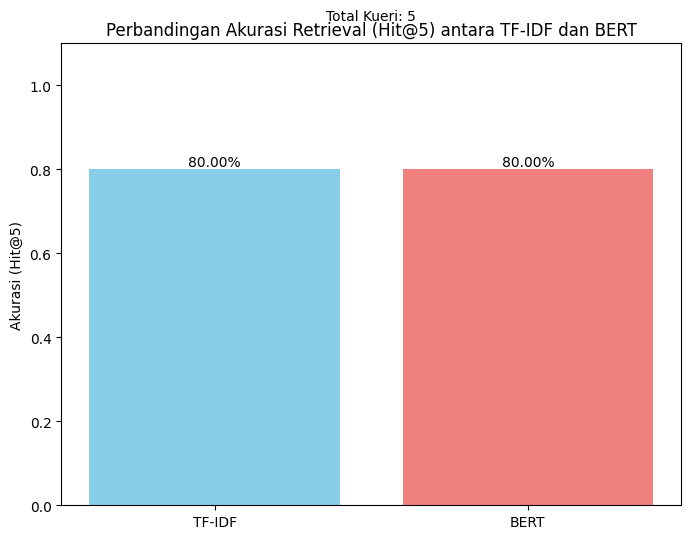

In [12]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['TF-IDF', 'BERT']
hits = [tfidf_hits_at_5, bert_hits_at_5]
total_queries = total_queries
accuracy = [h / total_queries for h in hits]

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(methods, accuracy, color=['skyblue', 'lightcoral'])

ax.set_ylabel('Akurasi (Hit@5)')
ax.set_title('Perbandingan Akurasi Retrieval (Hit@5) antara TF-IDF dan BERT')
ax.set_ylim(0, 1.1) # Batas y-axis dari 0 sampai 1.1 (untuk ruang label)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', ha='center') # Format sebagai persentase

plt.text(0.5, 1.05, f'Total Kueri: {total_queries}', ha='center', transform=ax.transAxes)

plt.show()


# Solution Reuse

## Persiapan Tahapan Solution Reuse

In [13]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import json

print("\n" + "="*50)
print("Persiapan untuk Tahap 4 - Solution Reuse")
print("="*50)

try:
    case_solutions = df.set_index('case_id')['amar'].to_dict()
    print("Langkah i: Kamus 'case_solutions' berhasil dibuat.")
except (NameError, KeyError):
    print("ERROR: Pastikan DataFrame 'df' sudah dimuat dan memiliki kolom 'case_id' & 'amar'.")
    exit()

def predict_outcome(query: str, k: int = 5):

    top_k_df = retrieve(query=query, method='bert', top_n=k)

    if top_k_df.empty:
        return "Tidak ditemukan kasus yang relevan.", pd.DataFrame()

    weighted_votes = {}
    for i, row in top_k_df.iterrows():
        solution_text = case_solutions.get(row['case_id'], None)
        if solution_text:
            weighted_votes[solution_text] = weighted_votes.get(solution_text, 0) + row['score']

    if not weighted_votes:
        return "Tidak ada solusi untuk diprediksi.", top_k_df

    predicted_solution = max(weighted_votes, key=weighted_votes.get)
    return predicted_solution, top_k_df


Persiapan untuk Tahap 4 - Solution Reuse
Langkah i: Kamus 'case_solutions' berhasil dibuat.


## Menjalankan Skrip Prediksi

In [14]:
print("\n" + "="*50)
print("iv. Menjalankan Skrip Prediksi & Demo Manual")
print("="*50)

json_path = '/content/drive/MyDrive/Penalaran/data/eval/queries.json'
with open(json_path, 'r') as f:
    queries_to_evaluate = json.load(f)

total_queries = len(queries_to_evaluate)
results_for_csv = []

print(f"Memulai prediksi untuk {total_queries} kasus baru...\n")

for i, item in enumerate(queries_to_evaluate):
    query_text = item['query']
    ground_truth_id = item['ground_truth_case_id']
    notes = item.get('notes', '')

    print(f"--- Prediksi untuk Kasus Baru #{i+1}: '{query_text}' ---")
    print(f"Ground Truth Case ID (untuk perbandingan): {ground_truth_id} | Notes: {notes}")

    predicted_solution, top_5_df = predict_outcome(query=query_text, k=5)

    actual_solution = case_solutions.get(ground_truth_id, "N/A")

    print("\n  Hasil Demo Manual:")
    print(f"    -> Prediksi Solusi: '{predicted_solution[:100]}...'")
    print(f"    -> Solusi Sebenarnya: '{actual_solution[:100]}...'")
    print(f"    -> Top 5 Kasus Terkait (IDs): {list(top_5_df['case_id'])}")

    top_5_ids_str = ", ".join(map(str, top_5_df['case_id'].tolist()))
    results_for_csv.append({
        'query_id': i + 1,
        'predicted_solution': predicted_solution,
        'top_5_case_ids': top_5_ids_str
    })

    print("-" * 60 + "\n")

print("\n" + "="*50)
print("v. Menghasilkan File Output 'predictions.csv'")
print("="*50)

results_dir = '/content/drive/MyDrive/Penalaran/data/results'
output_csv_path = os.path.join(results_dir, 'predictions.csv')
os.makedirs(results_dir, exist_ok=True)

predictions_df = pd.DataFrame(results_for_csv)
predictions_df.to_csv(output_csv_path, index=False)

print(f"1. Script 04_predict.py / notebook cell telah selesai dijalankan.")
print(f"2. File output berhasil disimpan di: '{output_csv_path}'")
print("\n   Konten dari 'predictions.csv':")
print(predictions_df.to_string())


iv. Menjalankan Skrip Prediksi & Demo Manual
Memulai prediksi untuk 5 kasus baru...

--- Prediksi untuk Kasus Baru #1: 'pencurian terdakwa saksi mahkamah agung republik indonesia' ---
Ground Truth Case ID (untuk perbandingan): 40 | Notes: Query referensi dari user (keyword-based).

  Hasil Demo Manual:
    -> Prediksi Solusi: 'Lain-lain...'
    -> Solusi Sebenarnya: 'Lain-lain...'
    -> Top 5 Kasus Terkait (IDs): [40, 1, 12, 69, 43]
------------------------------------------------------------

--- Prediksi untuk Kasus Baru #2: 'Terdakwa pencurian mengajukan banding ke Mahkamah Agung Republik Indonesia setelah kesaksian saksi memberatkannya' ---
Ground Truth Case ID (untuk perbandingan): 40 | Notes: Query semantik untuk kasus narkotika.

  Hasil Demo Manual:
    -> Prediksi Solusi: 'Lain-lain...'
    -> Solusi Sebenarnya: 'Lain-lain...'
    -> Top 5 Kasus Terkait (IDs): [40, 65, 8, 43, 59]
------------------------------------------------------------

--- Prediksi untuk Kasus Baru #3: 

# Model Evaluation


## Pemanggilan Fungsi Evaluasi

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

def calculate_metrics(df, tfidf_matrix, bert_embeddings_matrix):
    X_tfidf = tfidf_matrix
    X_bert = bert_embeddings_matrix
    y = df['label_klasifikasi']

    print("\n" + "="*50)
    print("Evaluasi Klasifikasi dengan TF-IDF dan BERT Embeddings")
    print("Menggunakan F1-score, Precision, dan Recall")
    print("="*50)

    if len(y.unique()) < 2:
        print("Tidak cukup kelas di kolom 'label_klasifikasi' untuk evaluasi.")
        print(y.value_counts())
        return None, None, None

    try:
        X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
            X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
        X_bert_train, X_bert_test, _, _ = train_test_split(
            X_bert, y, test_size=0.2, random_state=42, stratify=y)
    except ValueError as e:
        print(f"Error saat membagi data: {e}")
        print("Distribusi kelas:", y.value_counts())
        return None, None, None

    # TF-IDF
    svm_tfidf = SVC(kernel='linear')
    svm_tfidf.fit(X_tfidf_train, y_train)
    y_pred_tfidf = svm_tfidf.predict(X_tfidf_test)

    f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted', zero_division=0)
    precision_tfidf = precision_score(y_test, y_pred_tfidf, average='weighted', zero_division=0)
    recall_tfidf = recall_score(y_test, y_pred_tfidf, average='weighted', zero_division=0)

    print(f"Hasil Evaluasi TF-IDF:")
    print(f"  F1-score (weighted): {f1_tfidf:.4f}")
    print(f"  Precision (weighted): {precision_tfidf:.4f}")
    print(f"  Recall (weighted): {recall_tfidf:.4f}")

    # BERT
    svm_bert = SVC(kernel='linear')
    svm_bert.fit(X_bert_train, y_train)
    y_pred_bert = svm_bert.predict(X_bert_test)

    f1_bert = f1_score(y_test, y_pred_bert, average='weighted', zero_division=0)
    precision_bert = precision_score(y_test, y_pred_bert, average='weighted', zero_division=0)
    recall_bert = recall_score(y_test, y_pred_bert, average='weighted', zero_division=0)

    print(f"\nHasil Evaluasi BERT Embeddings:")
    print(f"  F1-score (weighted): {f1_bert:.4f}")
    print(f"  Precision (weighted): {precision_bert:.4f}")
    print(f"  Recall (weighted): {recall_bert:.4f}")

    metrics = ['F1-score', 'Precision', 'Recall']
    tfidf_scores = [f1_tfidf, precision_tfidf, recall_tfidf]
    bert_scores = [f1_bert, precision_bert, recall_bert]
    data = {
        'Metric': metrics * 2,
        'Score': tfidf_scores + bert_scores,
        'Model': ['TF-IDF'] * len(metrics) + ['BERT Embeddings'] * len(metrics)
    }
    df_metrics = pd.DataFrame(data)
    return df_metrics, metrics, tfidf_scores, bert_scores

## Ouput Evaluasi

In [20]:
if 'df_final' in locals() and 'tfidf_matrix' in locals() and 'doc_embeddings_matrix' in locals():
    df_metrics, metrics, tfidf_scores, bert_scores = calculate_metrics(df_final, tfidf_matrix, doc_embeddings_matrix)
    if df_metrics is not None:
        df_metrics.to_csv('/content/drive/MyDrive/Penalaran/data/eval/retrieval_metrics.csv', index=False)
        df_predictions = pd.DataFrame({
            'Metric': metrics,
            'TF-IDF': tfidf_scores,
            'BERT Embeddings': bert_scores
        })
        df_predictions.to_csv('/Content/drive/MyDrive/Penalaran/data/eval/prediction_metrics.csv', index=False)
elif 'df' in locals() and 'tfidf_matrix' in locals() and 'doc_embeddings_matrix' in locals():
    df_metrics, metrics, tfidf_scores, bert_scores = calculate_metrics(df, tfidf_matrix, doc_embeddings_matrix)
    if df_metrics is not None:
        df_metrics.to_csv('/content/drive/MyDrive/Penalaran/data/eval/retrieval_metrics.csv', index=False)
        df_predictions = pd.DataFrame({
            'Metric': metrics,
            'TF-IDF': tfidf_scores,
            'BERT Embeddings': bert_scores
        })
        df_predictions.to_csv('/content/drive/MyDrive/Penalaran/data/eval/prediction_metrics.csv', index=False)
else:
    print("\nError: Variabel DataFrame (df_final atau df), tfidf_matrix, atau doc_embeddings_matrix tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan semua sel di bagian preprocessing dan embedding sebelum evaluasi ini.")
    df_metrics, metrics, tfidf_scores, bert_scores = None, None, None, None


Evaluasi Klasifikasi dengan TF-IDF dan BERT Embeddings
Menggunakan F1-score, Precision, dan Recall
Hasil Evaluasi TF-IDF:
  F1-score (weighted): 0.6986
  Precision (weighted): 0.7300
  Recall (weighted): 0.7000

Hasil Evaluasi BERT Embeddings:
  F1-score (weighted): 0.5145
  Precision (weighted): 0.5773
  Recall (weighted): 0.5000


## Visualisasi Hasil

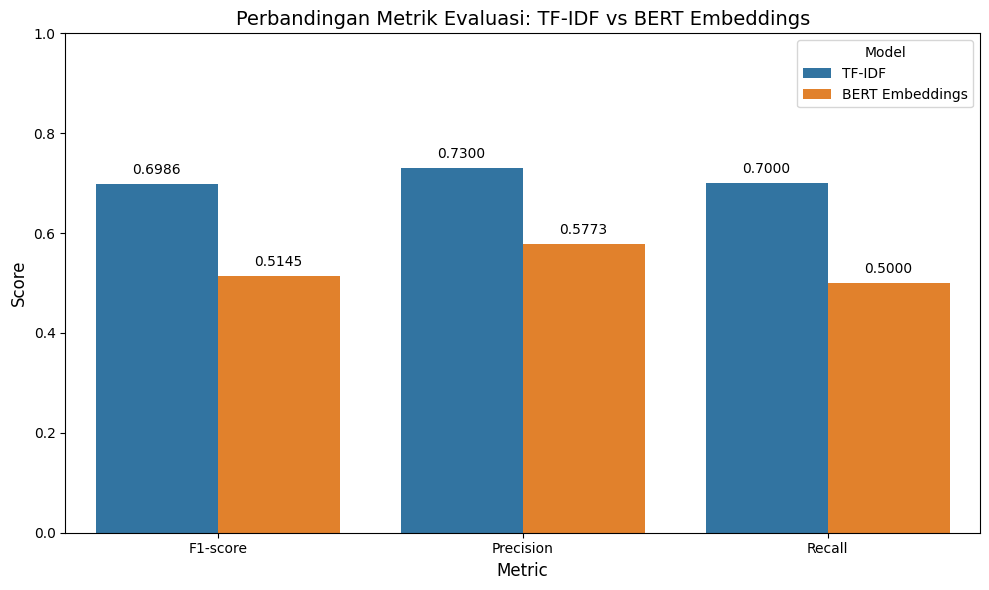

In [17]:
if df_metrics is not None:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics)
    plt.title('Perbandingan Metrik Evaluasi: TF-IDF vs BERT Embeddings', fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metric', fontsize=12)
    plt.ylim(0, 1)
    plt.legend(title='Model')
    for i in range(len(metrics)):
        plt.text(i - 0.2, tfidf_scores[i] + 0.02, f'{tfidf_scores[i]:.4f}', ha='center', fontsize=10)
        plt.text(i + 0.2, bert_scores[i] + 0.02, f'{bert_scores[i]:.4f}', ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()


Error Analysis untuk TF-IDF
Confusion Matrix:
[[4 3 0]
 [1 7 0]
 [2 0 3]]

Classification Report:
                 precision    recall  f1-score   support

          Berat       0.57      0.57      0.57         7
         Ringan       0.70      0.88      0.78         8
Tidak Ditemukan       1.00      0.60      0.75         5

       accuracy                           0.70        20
      macro avg       0.76      0.68      0.70        20
   weighted avg       0.73      0.70      0.70        20



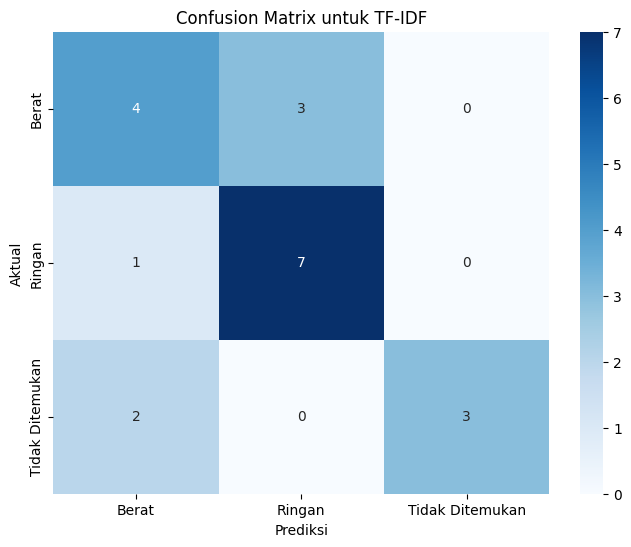


Error Analysis untuk BERT Embeddings
Confusion Matrix:
[[4 3 0]
 [5 3 0]
 [2 0 3]]

Classification Report:
                 precision    recall  f1-score   support

          Berat       0.36      0.57      0.44         7
         Ringan       0.50      0.38      0.43         8
Tidak Ditemukan       1.00      0.60      0.75         5

       accuracy                           0.50        20
      macro avg       0.62      0.52      0.54        20
   weighted avg       0.58      0.50      0.51        20



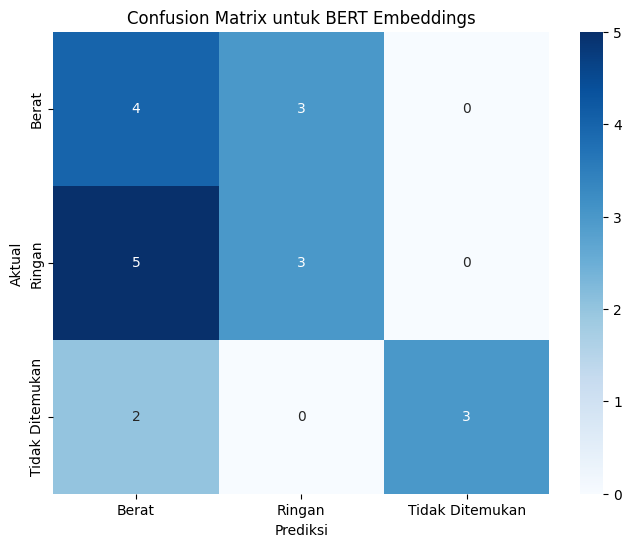


Contoh Kesalahan Prediksi untuk TF-IDF
Total kesalahan prediksi: 6

Contoh 3 data yang salah diprediksi:

Contoh 1:
Teks: Putusan PN MEDAN Nomor 2114/Pid.B/2023/PN Mdn Tanggal 13 Desember 2023 —Penuntut Umum:SILVIA PRATIWI YUNISARITerdakwa:HERY ZULHAM ALS ILHAM. Kasus ini terkait tindak pidana Pencurian. Terdakwa dijerat dengan 363 ayat (1) ke-4 dan ke-5 KUHPidana.2.Menjatuhkan pidana terhadap terdakwa HERY ZULHAM ALS ILHAM,dengan pidana penjara selama: 3 (tiga) tahun dan 6 (enam) bulan denganHalaman 1 dari 13 Putusan Nomor 2114/Pid.B/2023/PN MdnDirektori Putusan Mahkamah Agung Republik Indonesia putusan.mahkamahagung.go.id  Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia   Halaman 2  dikurangi selama terdakwa berada dalam tahanan sementara dan denganperintah agar terdakwa tetap ditahan.3.Menyatakan barang bukti berupa: 1 (satu) lembar STNK (Surat Tanda Nomor Ken

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def error_analysis(df, tfidf_matrix, bert_embeddings_matrix):
    X_tfidf = tfidf_matrix
    X_bert = bert_embeddings_matrix
    y = df['label_klasifikasi']

    # Split data
    X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
    X_bert_train, X_bert_test, _, _ = train_test_split(
        X_bert, y, test_size=0.2, random_state=42, stratify=y)

    # Prediksi untuk TF-IDF
    svm_tfidf = SVC(kernel='linear')
    svm_tfidf.fit(X_tfidf_train, y_train)
    y_pred_tfidf = svm_tfidf.predict(X_tfidf_test)

    # Prediksi untuk BERT
    svm_bert = SVC(kernel='linear')
    svm_bert.fit(X_bert_train, y_train)
    y_pred_bert = svm_bert.predict(X_bert_test)

    # Get unique labels for confusion matrix
    labels = np.unique(y)

    # Confusion Matrix dan Classification Report untuk TF-IDF
    print("\n" + "="*50)
    print("Error Analysis untuk TF-IDF")
    print("="*50)
    print("Confusion Matrix:")
    cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
    print(cm_tfidf)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_tfidf, zero_division=0))

    # Plot Confusion Matrix untuk TF-IDF
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix untuk TF-IDF')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

    # Confusion Matrix dan Classification Report untuk BERT Embeddings
    print("\n" + "="*50)
    print("Error Analysis untuk BERT Embeddings")
    print("="*50)
    print("Confusion Matrix:")
    cm_bert = confusion_matrix(y_test, y_pred_bert, labels=labels)
    print(cm_bert)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_bert, zero_division=0))

    # Plot Confusion Matrix untuk BERT Embeddings
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix untuk BERT Embeddings')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

    # Identifikasi contoh kesalahan untuk TF-IDF
    print("\n" + "="*50)
    print("Contoh Kesalahan Prediksi untuk TF-IDF")
    print("="*50)
    indices_test = y_test.index
    errors_tfidf = y_test != y_pred_tfidf
    error_indices_tfidf = indices_test[errors_tfidf]

    if len(error_indices_tfidf) > 0:
        print(f"Total kesalahan prediksi: {len(error_indices_tfidf)}")
        print("\nContoh 3 data yang salah diprediksi:")
        for i, idx in enumerate(error_indices_tfidf[:3]):
            print(f"\nContoh {i+1}:")
            print(f"Teks: {df.loc[idx, 'text_for_retrieval']}")
            print(f"Label Sebenarnya: {y_test.loc[idx]}")
            print(f"Prediksi: {y_pred_tfidf[errors_tfidf][i]}")
    else:
        print("Tidak ada kesalahan prediksi untuk TF-IDF.")

    # Identifikasi contoh kesalahan untuk BERT
    print("\n" + "="*50)
    print("Contoh Kesalahan Prediksi untuk BERT Embeddings")
    print("="*50)
    errors_bert = y_test != y_pred_bert
    error_indices_bert = indices_test[errors_bert]

    if len(error_indices_bert) > 0:
        print(f"Total kesalahan prediksi: {len(error_indices_bert)}")
        print("\nContoh 3 data yang salah diprediksi:")
        for i, idx in enumerate(error_indices_bert[:3]):
            print(f"\nContoh {i+1}:")
            print(f"Teks: {df.loc[idx, 'text_for_retrieval']}")
            print(f"Label Sebenarnya: {y_test.loc[idx]}")
            print(f"Prediksi: {y_pred_bert[errors_bert][i]}")
    else:
        print("Tidak ada kesalahan prediksi untuk BERT Embeddings.")

# Eksekusi error analysis
if 'df_final' in locals() and 'tfidf_matrix' in locals() and 'doc_embeddings_matrix' in locals():
    error_analysis(df_final, tfidf_matrix, doc_embeddings_matrix)
elif 'df' in locals() and 'tfidf_matrix' in locals() and 'doc_embeddings_matrix' in locals():
    error_analysis(df, tfidf_matrix, doc_embeddings_matrix)
else:
    print("\nError: Variabel DataFrame (df_final atau df), tfidf_matrix, atau doc_embeddings_matrix tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan semua sel di bagian preprocessing dan embedding sebelum evaluasi ini.")